## Import Necessary Libraries

Imports several essential libraries that will be used throughout the notebook for various tasks such as image processing, data handling, and visualization.

- **`numpy`**: Used for numerical computations and handling arrays.
- **`pandas`**: A powerful data manipulation library, typically used for handling structured data in tabular form.
- **`cv2` (OpenCV)**: A widely-used library for computer vision tasks, including reading, writing, and manipulating images.
- **`os`**: This library is used for interacting with the operating system, such as file directory operations.
- **`matplotlib.pyplot`**: A plotting library used to visualize data and images.
- **`google.colab.patches.cv2_imshow`**: A special function to display images within Colab using OpenCV (since `cv2.imshow()` doesn’t work natively in Colab).

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Download and Unzip the American Sign Language (ASL) Dataset

In this cell, we download the American Sign Language (ASL) dataset from a remote source and unzip it into the current directory. The dataset will be used for training and testing the YOLOv8 model.

### Step 1: Download the Dataset
- **`requests.get()`**: This function sends an HTTP GET request to the URL hosting the dataset and downloads the file content.
- **`with open()`**: This creates a new file named `asl_dataset.zip` and writes the downloaded content into this file.
- **Progress Message**: A print statement is used to indicate when the dataset download starts.

### Step 2: Unzip the Dataset
- **`zipfile.ZipFile()`**: This opens the downloaded `.zip` file.
- **`extractall()`**: This method extracts all the files from the zip archive into the current directory.
- **Progress Message**: A print statement is used to indicate when the unzipping starts.

After running this cell, the ASL dataset will be downloaded and extracted, ready for use in further processing and training.

In [2]:
# Import necessary libraries for downloading and unzipping the dataset
import requests  # For sending HTTP requests to download the dataset
import zipfile  # For unzipping the downloaded file
from pathlib import Path  # For managing file paths

# Download the ASL dataset from the provided URL
with open("asl_dataset.zip", "wb") as f:
    request = requests.get("https://drive.google.com/uc?export=download&id=1k14Sztb7Gtc73SL4bxr12Y8N9xYCW3Vv")  # Download the dataset
    print("Downloading ASL Dataset...")  # Progress message
    f.write(request.content)  # Write the downloaded content to a zip file

In [3]:
# Unzip the downloaded ASL dataset
with zipfile.ZipFile("asl_dataset.zip", "r") as zip_ref:
    print("Unzipping ASL Dataset...")  # Progress message
    zip_ref.extractall()  # Extract all the files to the current directory

Unzipping ASL Dataset...


## Exploring and Visualizing the Dataset Before Training the Model

Before training any model, it's crucial to understand and visualize the dataset. This ensures that the images and corresponding labels are properly loaded and correctly formatted. Here, we will display one of the training images, inspect its dimensions, and visualize the corresponding bounding box annotations.

### Step 1: Load the Dataset

We begin by loading the file paths of the images in the training set using the `glob` module. This step ensures that we can access the dataset files properly.

In [4]:
# Import the glob module to retrieve file paths from the dataset directory
import glob

# Retrieve all file paths from the 'train/images' folder in the dataset
paths = glob.glob('/content/train/images/*')

# Print the first image file path to confirm successful loading
paths[0]

'/content/train/images/K4_jpg.rf.605ce13ae422d6f639de55692691009e.jpg'

### Step 2: Load and Display an Image

Using OpenCV, we read the first image from the dataset and display it in the notebook. We also check the dimensions of the image to understand its height, width, and the number of channels (whether it’s a grayscale or color image).

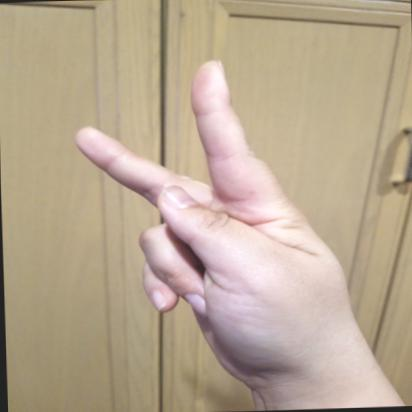

(412, 412, 3)

In [5]:
img = cv2.imread(paths[0])
cv2_imshow(img)  # Display the image
img.shape  # Print the image dimensions (height, width, channels)

###Step 3: Load and Display the Corresponding Labels

The dataset is likely structured in YOLO format, where for each image, there’s a corresponding label file that contains information about the bounding boxes. Each label file has the same name as the image but is stored in the labels folder instead of images, and its extension is .txt.

We load the label file for the image and split the contents to extract the bounding box information, which is stored as normalized values.

In [6]:
label_path=paths[0].replace('images','labels').replace('.jpg','.txt')
label_path

'/content/train/labels/K4_jpg.rf.605ce13ae422d6f639de55692691009e.txt'

In [7]:
with open(label_path,'r') as f:
  label=f.read()
label_list=label.split(' ')
label_list

['10',
 '0.5196900339898288',
 '0.536445880059103',
 '0.7183121896262613',
 '0.8310624456625552']

###Step 4: Convert Normalized Bounding Box Values to Pixel Coordinates

The bounding box coordinates in the label file are provided as normalized values (between 0 and 1). These values represent:

		The class ID (which letter the sign represents).
		The center coordinates of the bounding box (x_center, y_center).
		The width and height of the bounding box.

We convert these normalized values into pixel coordinates using the image dimensions so that we can draw the bounding box on the image.

- $x_{\text{min}} = (x_{\text{center}} - \frac{\text{width}}{2}) \times \text{image width}$

- $y_{\text{min}} = (y_{\text{center}} - \frac{\text{height}}{2}) \times \text{image height} $

- $ x_{\text{max}} = (x_{\text{center}} + \frac{\text{width}}{2}) \times \text{image width} $

- $ y_{\text{max}} = (y_{\text{center}} + \frac{\text{height}}{2}) \times \text{image height} $

In [8]:
img_height, img_width = img.shape[:2]

# label_list contains normalized center coordinates and width/height
class_id = int(label_list[0])  # Class ID from the label list
x_center = float(label_list[1])
y_center = float(label_list[2])
bbox_width = float(label_list[3])
bbox_height = float(label_list[4])

# Convert normalized center coordinates and dimensions to pixel values
x_min = int((x_center - bbox_width / 2) * img_width)
y_min = int((y_center - bbox_height / 2) * img_height)
x_max = int((x_center + bbox_width / 2) * img_width)
y_max = int((y_center + bbox_height / 2) * img_height)

# Print the results
print(f"Class ID: {class_id}")
print(f"x_min: {x_min}, y_min: {y_min}")
print(f"x_max: {x_max}, y_max: {y_max}")

Class ID: 10
x_min: 66, y_min: 49
x_max: 362, y_max: 392


###Step 5: Draw the Bounding Box on the Image

We now use OpenCV’s cv2.rectangle() function to draw the bounding box on the image. This helps us visualize the annotations provided in the dataset and ensures that they are correct before we proceed to train the model.

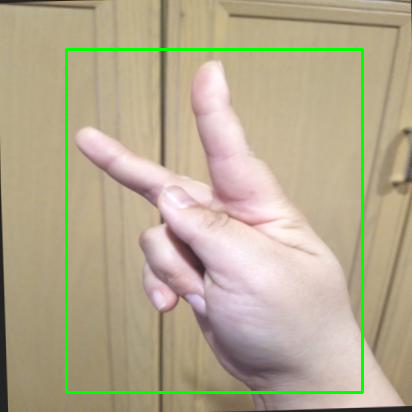

In [9]:
cv2.rectangle(img,(x_min,y_min),(x_max,y_max),(0,255,0),2)
cv2_imshow(img)

## Install the YOLOv8 Package (Ultralytics)

Now, we install the `ultralytics` package, which provides the implementation for the YOLOv8 object detection model. YOLO (You Only Look Once) is a popular real-time object detection algorithm known for its speed and accuracy.

- **`!pip install ultralytics`**: This command installs the `ultralytics` package, which contains the YOLOv8 model and related functionalities for training, validation, and inference.

This step is necessary to use YOLOv8 for object detection tasks, such as detecting objects in the American Sign Language dataset.

In [10]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 50.4 MB/s eta 0:00:00


In [11]:
# Importing the torch library for PyTorch operations
import torch

# Checking if a GPU is available for use
torch.cuda.is_available()

True

## Training the YOLOv8 Model with Custom Dataset

This cell loads a pre-trained YOLOv8 model (nano version) and trains it on a custom dataset. The training process is configured with specific parameters such as the number of epochs, image size, and hardware device (GPU/CPU). Additionally, the logging system (Weights & Biases) is disabled for simplicity.

### Step 1: Disable Weights & Biases Logging
- **`os.environ['WANDB_MODE'] = 'disabled'`**: This disables the automatic logging to Weights & Biases (WandB), which is a tool for tracking machine learning experiments. Disabling it simplifies the environment by preventing external logging.

### Step 2: Load the Pre-trained YOLOv8 Model
- **`YOLO("yolov8n.pt")`**: This loads the pre-trained YOLOv8 nano model (`yolov8n.pt`), which is a lightweight version optimized for fast training and inference. The pre-trained model will be fine-tuned on the custom dataset.

### Step 3: Train the Model
- **`model.train()`**: This method starts the training process.
- **`data="data.yaml"`**: The path to the dataset configuration file (YAML format), which specifies information about the dataset, such as the class names and the paths to images and labels.
- **`epochs=10`**: The model will be trained for 10 epochs (iterations over the entire dataset).
- **`imgsz=640`**: The training images will be resized to 640x640 pixels, ensuring uniformity in input size.
- **`device='cuda' if torch.cuda.is_available() else 'cpu'`**: This ensures that the training will take advantage of the GPU (if available) or fallback to the CPU if no GPU is detected.

Running this cell will begin training the YOLOv8 model on the custom dataset, either using the GPU for faster computation or the CPU if a GPU is not available.

In [12]:
from ultralytics import YOLO

# Disable Weights & Biases (WandB) logging to simplify the environment
os.environ['WANDB_MODE'] = 'disabled'

model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
train_results = model.train(
    data="data.yaml",  # path to dataset YAML
    epochs=10,  # number of training epochs
    imgsz=640,  # training image size
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 376MB/s]

Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False,

100%|██████████| 755k/755k [00:00<00:00, 100MB/s]


Overriding model.yaml nc=80 with nc=26

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 268MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 1512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1512/1512 [00:00<00:00, 1885.38it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/valid/labels... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<00:00, 1117.23it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.27G     0.8842      4.706      1.472          8        640: 100%|██████████| 95/95 [00:33<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        144        144       0.62      0.139      0.242      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.24G     0.6711      3.731      1.235          8        640: 100%|██████████| 95/95 [00:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        144        144      0.686      0.362      0.489      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.24G     0.6276      2.994      1.187          8        640: 100%|██████████| 95/95 [00:26<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

                   all        144        144      0.623      0.582      0.703      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.23G     0.6005      2.385      1.143          8        640: 100%|██████████| 95/95 [00:27<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        144        144      0.636      0.723      0.789      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.23G     0.5739       1.99      1.109          8        640: 100%|██████████| 95/95 [00:30<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        144        144      0.692      0.786      0.861      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.23G     0.5445       1.73      1.083          8        640: 100%|██████████| 95/95 [00:27<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        144        144      0.857      0.782      0.895      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.23G     0.5321      1.519      1.059          8        640: 100%|██████████| 95/95 [00:25<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        144        144       0.86      0.802      0.916      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.23G     0.5024      1.378       1.04          8        640: 100%|██████████| 95/95 [00:32<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

                   all        144        144      0.882      0.769      0.917       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.23G      0.478      1.274      1.025          8        640: 100%|██████████| 95/95 [00:29<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all        144        144      0.841      0.828      0.919      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.23G     0.4621      1.204     0.9955          8        640: 100%|██████████| 95/95 [00:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        144        144      0.867      0.845      0.939      0.772



10 epochs completed in 0.089 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


                   all        144        144      0.867      0.846      0.938      0.771
                     A          5          5      0.811      0.866      0.862      0.676
                     B          9          9          1      0.946      0.995      0.828
                     C          3          3      0.897          1      0.995       0.83
                     D          6          6      0.807          1      0.972      0.841
                     E          4          4      0.755          1      0.995      0.838
                     F          8          8      0.872          1      0.995       0.83
                     G          5          5      0.921          1      0.995      0.851
                     H          9          9          1      0.892      0.995      0.739
                     I          2          2      0.434        0.5       0.54      0.486
                     J          8          8          1      0.892      0.995      0.652
                     

## Testing the Trained YOLOv8 Model on a New Image

In this cell, we load the trained YOLOv8 model and test it on a new image from the dataset. The trained model is used to detect objects (ASL letters) in the test image.

### Step 1: Load the Trained YOLOv8 Model
- **`YOLO('best.pt')`**: This loads the YOLOv8 model with the weights obtained after training (the `best.pt` file). These weights represent the model that performed best during the training process.
  
### Step 2: Load the Test Image
- **`cv2.imread()`**: This function loads the test image from the dataset. In this case, the image is from the `test/images` folder, and it's an ASL letter image.

### Step 3: Perform Object Detection
- **`results = model_test(img)`**: The model makes predictions on the test image. This runs the YOLOv8 model on the image to detect objects (ASL letters). The output `results` contains the detected objects, their bounding boxes, and class predictions.

By running this cell, the trained YOLOv8 model will process the image and return predictions on the objects (ASL letters) present in the image.

In [13]:
model_test=YOLO('/content/runs/detect/train/weights/best.pt')

img=cv2.imread('/content/test/images/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg')

results=model_test(img)


0: 640x640 1 A, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


array([[[252, 255, 251],
        [252, 255, 251],
        [252, 255, 251],
        ...,
        [ 19,  33,  52],
        [ 13,  27,  46],
        [  9,  23,  42]],

       [[252, 255, 251],
        [252, 255, 251],
        [252, 255, 251],
        ...,
        [ 18,  32,  51],
        [ 14,  28,  47],
        [ 12,  26,  45]],

       [[254, 255, 253],
        [254, 255, 253],
        [254, 255, 253],
        ...,
        [ 23,  35,  53],
        [ 21,  33,  51],
        [ 20,  32,  50]],

       ...,

       [[ 15,  79, 134],
        [ 17,  81, 136],
        [ 18,  82, 137],
        ...,
        [ 17,  78, 122],
        [ 18,  79, 123],
        [ 18,  79, 123]],

       [[ 13,  78, 133],
        [ 15,  80, 135],
        [ 17,  82, 137],
        ...,
        [ 14,  77, 121],
        [ 15,  78, 122],
        [ 16,  79, 123]],

       [[ 12,  77, 132],
        [ 14,  79, 134],
        [ 17,  82, 137],
        ...,
        [ 12,  75, 119],
        [ 13,  76, 120],
        [ 13,  76, 120]]], dtype=uint8)
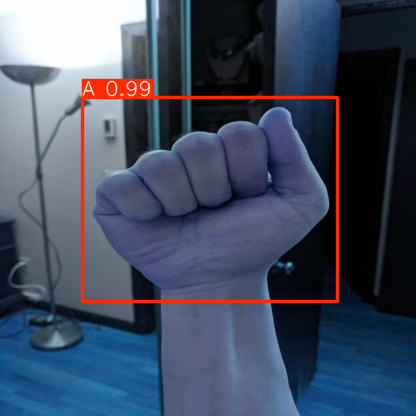

In [14]:
results[0].plot()